<img src="https://gist.githubusercontent.com/nesnoj/6ee605cd3494fa6e3e848385c4afbe19/raw/a883b1bdc69c0c5bbb0b00ba92f43033aa86ec64/dingo_model.png" alt="DINGO Model" width="800"  align="center">

In [1]:
%%capture

from ding0.core import NetworkDing0
from ding0.tools.logger import setup_logger
from ding0.tools.results import save_nd_to_pickle
from ding0.tools.plots import plot_mv_topology
from egoio.tools import db
from sqlalchemy.orm import sessionmaker
import oedialect

# create new network
nd = NetworkDing0(name='network')



# set ID of MV grid district
mv_grid_districts = [40] # fn

In [2]:
engine = db.connection(section='oedb_dialect', readonly=True)
session = sessionmaker(bind=engine)()

In [3]:
# due to load_nd_from_pickle
from ding0.tools import results

In [4]:
load_from_pkl=True

if load_from_pkl:
    
    print('LOAD DING0 GRID FROM PKL')

    grid_id=40
    nd = results.load_nd_from_pickle(filename='./config/tmp/ding0_grids__' + str(grid_id) + '.pkl')
    
    # should be closed before export
    nd.control_circuit_breakers(mode='open')


else:
    
    print('DING0.RUN()')
    
    nd.import_mv_grid_districts(session, mv_grid_districts_no=mv_grid_districts)
    nd.import_generators(session)

    nd.mv_parametrize_grid()
    nd.validate_grid_districts()
    
    build_lv_grid_default=True

    if build_lv_grid_default:

        nd.build_lv_grids()

    else:

        print('IMPLEMENT_MY_ROUTING')
        
        
    nd.mv_routing()
    
    nd.connect_generators()
    #nd.set_branch_ids()
    nd.set_circuit_breakers()
    
    
    nd.control_circuit_breakers(mode='open')
    nd.run_powerflow(session)
    
    nd.reinforce_grid()
    
    
    
    #nd.control_circuit_breakers(mode='close')
    #save_nd_to_pickle(nd, filename='ding0_grids__40.pkl')

LOAD DING0 GRID FROM PKL


In [5]:
import networkx as nx # to enable nx.draw()
import pandas as pd
from sqlalchemy import func
from geoalchemy2.shape import to_shape 
from shapely.wkt import loads

In [6]:
from config.config_lv_grids_osm import get_config_osm 
from config.db_conn_local_bw_sandbox import get_session_osm
from config.classes_db_conn.osm_load_classes import Buildings_with_Amenities, Building_wo_Amenity, Amenities_ni_Buildings, Way

In [7]:
from grid.lv_grid.routing import build_graph_from_ways, nearest_nodes, get_location_substation_at_pi
from grid.lv_grid.parameterization import parameterize_by_load_profiles
from grid.lv_grid.clustering import get_n_cluster, cluster_k_means

In [8]:
from grid.lv_grid.geo import get_Point_from_x_y, get_points_in_load_area, get_convex_hull_from_points

In [9]:
session_osm = get_session_osm()

In [10]:
# FOR TESTING REASONS SELECT ONE LOAD_AREA (Fallenbrunnen) BY ID
id_load_area_fallenbrunnen = '4544'

load_areas = []


for mv_grid_district in nd.mv_grid_districts():
    for load_area in mv_grid_district.lv_load_areas():
        
        
        if not load_area.is_aggregated:
                
            if id_load_area_fallenbrunnen in str(load_area):
                
                fn_fallenbrunnen_la  = load_area
                fn_fallenbrunnen_geo = fn_fallenbrunnen_la.geo_area
                
                #for lv_district in fn_fallenbrunnen_la._lv_grid_districts:
                # does not work due to one districtr has 1 lv station where trafo is located
            
                print('build a lv grid for ', str(load_area))
                print('peak_load by ding0', load_area.peak_load)
                print('STARTING SYNTHESIZING LV GRIDS FOR load_area')

                print('CALL')

                print('SYNTHESIZING LV GRIDS for LA TERMINATED')
                
                
        # if only is_aggregated
        #    indent
        load_areas.append(load_area)
                                
                

build a lv grid for  lv_load_area_4544
peak_load by ding0 27.9485612387548
STARTING SYNTHESIZING LV GRIDS FOR load_area
CALL
SYNTHESIZING LV GRIDS for LA TERMINATED


In [11]:
# load ways and buildings...

### Load bays
ways = session_osm.query(Way).filter(func.st_intersects(func.ST_GeomFromText(fn_fallenbrunnen_geo.wkt, get_config_osm('srid')), Way.geometry)) 


graph, node_coords_dict = build_graph_from_ways(ways)
#nx.draw(graph, node_coords_dict)


### Load buildings_w_a
buildings_w_a = session_osm.query(Buildings_with_Amenities).filter(func.st_intersects(func.ST_GeomFromText(fn_fallenbrunnen_geo.wkt, get_config_osm('srid')), Buildings_with_Amenities.geometry_amenity)) 

### Load buildings_wo_a
#buildings_wo_a = session_osm.query(Building_wo_Amenity).filter(func.st_intersects(func.ST_GeomFromText(fn_fallenbrunnen_geo.wkt, config_osm['srid']), Building_wo_Amenity.geometry)) 
buildings_wo_a = session_osm.query(Building_wo_Amenity).filter(func.st_intersects(func.ST_GeomFromText(fn_fallenbrunnen_geo.wkt, get_config_osm('srid')), Building_wo_Amenity.geometry)) 

### Load buildings_wo_a
#amenities_ni_Buildings = session_osm.query(Amenities_ni_Buildings).filter(func.st_intersects(func.ST_GeomFromText(fn_fallenbrunnen_geo.wkt, config_osm['srid']), Amenities_ni_Buildings.geometry)) 
amenities_ni_Buildings = session_osm.query(Amenities_ni_Buildings).filter(func.st_intersects(func.ST_GeomFromText(fn_fallenbrunnen_geo.wkt, get_config_osm('srid')), Amenities_ni_Buildings.geometry)) 


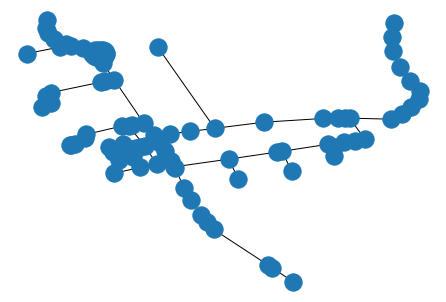

In [12]:
nx.draw(graph, node_coords_dict)

#### ADD LOADS and ASSIGN NN

In [13]:
%%time

buildings_w_loads_df = parameterize_by_load_profiles(buildings_w_a, buildings_wo_a, amenities_ni_Buildings)

X = buildings_w_loads_df['x'].tolist()
Y = buildings_w_loads_df['y'].tolist()
    
buildings_w_loads_df['nn'], buildings_w_loads_df['nn_dist'] = nearest_nodes(graph, X, Y)


Wall time: 14.5 s


### Clustering

In [14]:
n_clusters = get_n_cluster(buildings_w_loads_df)
if n_clusters < len(fn_fallenbrunnen_la._lv_grid_districts):
    n_clusters = len(fn_fallenbrunnen_la._lv_grid_districts)
buildings_w_loads_df = cluster_k_means(buildings_w_loads_df, n_clusters)

### Update and add _districts

In [15]:
buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)]

,category,capacity,number_households,x,y,geometry,nn,nn_dist,Cluster
osm_id,,,,,,,,,
35318091,dormitory,88.840440,52.0,9.443895,47.667216,"POLYGON ((9.443008799999998 47.66745990001561,...",2927393550,40.266932,0
222184229,university,46.540341,0.0,9.444999,47.664924,"POLYGON ((9.444854599999998 47.66499900001618,...",2311661357,24.986495,0
247479384,restaurant,158.595981,0.0,9.444379,47.665467,"POLYGON ((9.4440598 47.665758600016, 9.4441263...",3840636444,12.316928,0
249601890,cinema,200.692980,0.0,9.444379,47.665467,"POLYGON ((9.4440598 47.665758600016, 9.4441263...",3840636444,12.316928,0
1510094884,bar,158.595981,0.0,9.444379,47.665467,"POLYGON ((9.4440598 47.665758600016, 9.4441263...",3840636444,12.316928,0
1510098931,theatre,200.692980,0.0,9.444379,47.665467,"POLYGON ((9.4440598 47.665758600016, 9.4441263...",3840636444,12.316928,0
2427156009,university,304.811100,0.0,9.444427,47.666355,"POLYGON ((9.443543500000001 47.66659780001582,...",2927393547,39.824731,0


In [16]:
%%time

geometry = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0), 'geometry'].tolist()

points = get_points_in_load_area(geometry)
        
len(points)

Wall time: 9.38 ms


140

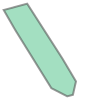

In [17]:
get_convex_hull_from_points(points)

In [24]:
fn_fallenbrunnen_la.lv_load_area_group.__dict__

{'id_db': 20,
 'mv_grid_district': mv_grid_district_40,
 '_lv_load_areas': [lv_load_area_4544,
  lv_load_area_4545,
  lv_load_area_4548,
  MVCableDist_mvgd_40_26],
 'peak_load': 65.35928151751943,
 'branch_length_sum': 0,
 'peak_load_max': 1000.0,
 'branch_length_max': 2000.0,
 'root_node': MVCableDist_mvgd_40_23}

In [28]:
nd._mv_grid_districts[0].__dict__

{'id_db': 40,
 'mv_grid': mv_grid_40,
 '_lv_load_areas': [lv_load_area_2128,
  lv_load_area_2292,
  lv_load_area_2383,
  lv_load_area_2520,
  lv_load_area_2521,
  lv_load_area_2561,
  lv_load_area_2608,
  lv_load_area_2625,
  lv_load_area_2633,
  lv_load_area_2705,
  lv_load_area_2728,
  lv_load_area_2763,
  lv_load_area_2765,
  lv_load_area_2840,
  lv_load_area_2842,
  lv_load_area_3029,
  lv_load_area_3088,
  lv_load_area_3089,
  lv_load_area_3119,
  lv_load_area_3160,
  lv_load_area_3235,
  lv_load_area_3277,
  lv_load_area_3304,
  lv_load_area_3305,
  lv_load_area_3307,
  lv_load_area_3311,
  lv_load_area_3314,
  lv_load_area_3403,
  lv_load_area_3413,
  lv_load_area_3645,
  lv_load_area_3661,
  lv_load_area_3731,
  lv_load_area_3780,
  lv_load_area_3805,
  lv_load_area_3911,
  lv_load_area_3986,
  lv_load_area_3987,
  lv_load_area_3992,
  lv_load_area_4212,
  lv_load_area_4337,
  lv_load_area_4347,
  lv_load_area_4487,
  lv_load_area_4488,
  lv_load_area_4544,
  lv_load_area_4545,

In [17]:
fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.__dict__

{'id_db': 4563,
 'geo_data': <shapely.geometry.point.Point at 0x118800eba90>,
 'grid': lv_grid_4563,
 '_transformers': [Transformer_lv_grid_4563_1],
 'v_level_operation': None,
 'lv_load_area': lv_load_area_4544,
 'voltage_res': [0.9897135909377942, 1.0123145234795161]}

In [17]:
preprocessed_clusters = []   
    

for cluster_id in range(n_clusters):
    
    if cluster_id < len(fn_fallenbrunnen_la._lv_grid_districts):
        
        print('delete or update _lv_grid_districts[', cluster_id, ']')
        
        # GET NEW VALUES FOR DISTRICT        
        # get convex hull of cluster
        points = get_points_in_load_area(buildings_w_loads_df.loc[buildings_w_loads_df['Cluster']==cluster_id])
        district_convex_hull = get_convex_hull_from_points(points)
        
        # get location of substation for cluster
        station_x, station_y = get_location_substation_at_pi(graph, buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)])

        
        # UPDATE VALUES
        # update values of _lv_grid_districts[cluster_id]
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].geo_data  = district_convex_hull
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].poulation = buildings_w_loads_df.loc[buildings_w_loads_df['Cluster']==cluster_id]['number_households'].sum()
        
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].peak_load = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)]['capacity'].sum()
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].peak_load_residential = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==cluster_id) & buildings_w_loads_df['number_households'] > 0]['capacity'].sum()
        
        
        # ADD / RESET DING0 ELEMENTS
        # update position of substation
        fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.geo_data = get_Point_from_x_y(station_x, station_y)
        
        # reset list to add new elements
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].lv_grid._station.transformers.clear()
        
        
        # update trafo and loads
        #fn_fallenbrunnen_la._lv_grid_districts[cluster_id].lv_grid.build_grid()
        
        
    else:
        
        print('add _lv_grid_districts id', cluster_id)
        
        
        
        
        
    break
    

update _lv_grid_districts 0
add _lv_grid_districts id 1
add _lv_grid_districts id 2


In [21]:
fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.__dict__

{'id_db': 4563,
 'geo_data': <shapely.geometry.point.Point at 0x1d50cd257f0>,
 'grid': lv_grid_4563,
 '_transformers': [Transformer_lv_grid_4563_1],
 'v_level_operation': None,
 'lv_load_area': lv_load_area_4544,
 'voltage_res': [0.9897135909377942, 1.0123145234795161]}

In [19]:
#lv_district_of_interest.lv_grid.graph_draw(mode='LV')

In [16]:
lv_district_of_interest.lv_grid.__dict__ # .geo_data.wkt

NameError: name 'lv_district_of_interest' is not defined

In [19]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [20]:
X = []    # collect nodes

for node in graph.nodes:

    X.append([graph.nodes[node]['X'], graph.nodes[node]['Y']])
    
    
X = np.array(X)



# clustering

adj_mat_sparse = nx.adjacency_matrix(graph, weight='length')

clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=adj_mat_sparse).fit(X)






# assign cluster labels

i_label = 0

for node in list(graph.nodes):

    graph.nodes[node]['cluster'] = clustering.labels_[i_label]
    
    i_label += 1
    
labels = nx.get_node_attributes(graph, 'cluster') 

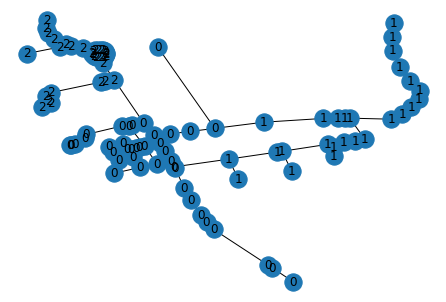

In [23]:
nx.draw(graph, node_coords_dict,labels=labels)

In [24]:
X = []    # collect nodes

for node in graph.nodes:

    X.append([graph.nodes[node]['X'], graph.nodes[node]['Y']])
    
    
X = np.array(X)



# clustering

adj_mat_sparse = nx.to_numpy_matrix(graph, weight='length')

clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=adj_mat_sparse).fit(X)






# assign cluster labels

i_label = 0

for node in list(graph.nodes):

    graph.nodes[node]['cluster'] = clustering.labels_[i_label]
    
    i_label += 1
    
labels = nx.get_node_attributes(graph, 'cluster') 

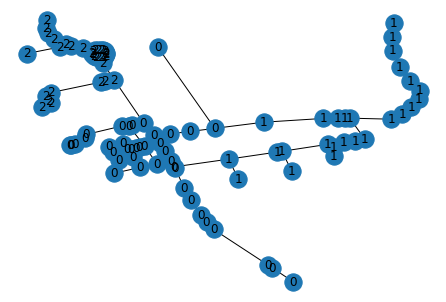

In [25]:
nx.draw(graph, node_coords_dict,labels=labels)